In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 200
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
print("lag time: ", lag_time)
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

lag time:  0.1


Simulating trajectories: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

Shape of data_matrix: (10, 201, 1)
Shape of data_X: (10, 200, 1)
Shape of data_Y: (10, 200, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)
(1400, 1)


In [ ]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [6]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.587912 val loss: 0.557813
saving, val loss enhanced: 0.5578129881494203 10000
Epoch: 2 	Training Loss: 0.583640 val loss: 0.554072
saving, val loss enhanced: 0.5540719546693751 0.5578129881494203
Epoch: 3 	Training Loss: 0.579531 val loss: 0.549818
saving, val loss enhanced: 0.549818272697615 0.5540719546693751
Epoch: 4 	Training Loss: 0.575863 val loss: 0.545183
saving, val loss enhanced: 0.5451830340773848 0.549818272697615
Epoch: 5 	Training Loss: 0.571480 val loss: 0.541607
saving, val loss enhanced: 0.5416070985895142 0.5451830340773848
Epoch: 6 	Training Loss: 0.567623 val loss: 0.537919
saving, val loss enhanced: 0.5379193648393343 0.5416070985895142
Epoch: 7 	Training Loss: 0.563932 val loss: 0.533742
saving, val loss enhanced: 0.5337420343246848 0.5379193648393343
Epoch: 8 	Training Loss: 0.559706 val loss: 0.531151
saving, val loss enhanced: 0.5311509356465264 0.5337420343246848
Epoch: 9 	Training Loss: 0.555809 val loss: 0.525623
saving, val loss e

Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7978.15iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_ou.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7939.85iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 717.505913 val loss: 532.257865
saving, val loss enhanced: 532.2578646674102 1000000000000000.0
Epoch: 2 	Training Loss: 713.939717 val loss: 529.709833
saving, val loss enhanced: 529.7098328278651 532.2578646674102
Epoch: 3 	Training Loss: 710.381353 val loss: 527.165499
saving, val loss enhanced: 527.1654987665346 529.7098328278651


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 4 	Training Loss: 706.834300 val loss: 524.629697
saving, val loss enhanced: 524.6296970088549 527.1654987665346
Epoch 1 time: 7.99 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8061.05iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 723.391473 val loss: 536.273590
Epoch: 2 	Training Loss: 719.782253 val loss: 533.690962
Epoch: 3 	Training Loss: 716.179918 val loss: 531.117067
Epoch: 4 	Training Loss: 712.591278 val loss: 528.554719
Epoch 2 time: 5.82 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9092.05iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 732.736661 val loss: 542.893782
Epoch: 2 	Training Loss: 729.060938 val loss: 540.263758
Epoch: 3 	Training Loss: 725.388063 val loss: 537.641389
Epoch: 4 	Training Loss: 721.728329 val loss: 535.031131
Epoch 3 time: 7.28 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8944.87iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 743.478756 val loss: 550.702686
Epoch: 2 	Training Loss: 739.717533 val loss: 548.012670
Epoch: 3 	Training Loss: 735.957535 val loss: 545.330097
Epoch: 4 	Training Loss: 732.211073 val loss: 542.660403
Epoch 4 time: 6.72 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8254.95iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 753.173467 val loss: 557.895091
Epoch: 2 	Training Loss: 749.330431 val loss: 555.148900
Epoch: 3 	Training Loss: 745.490077 val loss: 552.411129
Epoch: 4 	Training Loss: 741.664734 val loss: 549.687262
Epoch 5 time: 7.10 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8678.20iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 762.998307 val loss: 565.254389
Epoch: 2 	Training Loss: 759.075030 val loss: 562.452323
Epoch: 3 	Training Loss: 755.154639 val loss: 559.659017
Epoch: 4 	Training Loss: 751.249932 val loss: 556.880205
Epoch 6 time: 6.87 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [7]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict,
    'K': Koopman_matrix_K
    }

[-3.02414734e-05+0.j -8.67371272e-01+0.j -1.80747922e+00+0.j
 -3.04442975e+00+0.j]


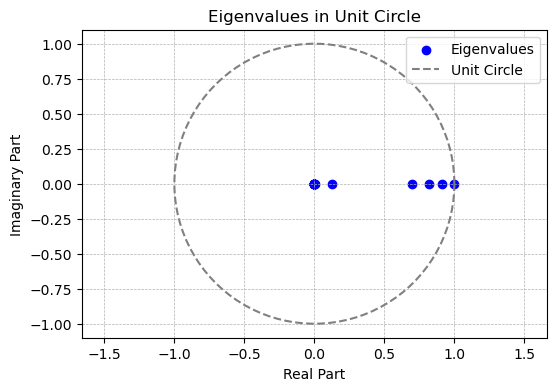

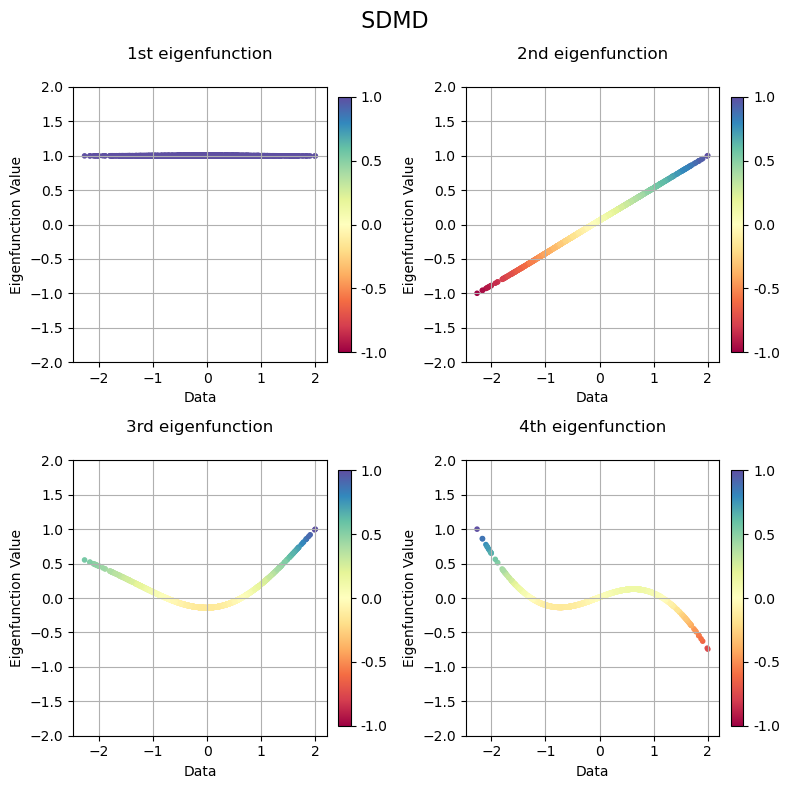

In [8]:
# Take ln values of the eigenvalues and divide by 0.1
# ln_evalues = np.log(evalues[:4]) / lag_time
ln_evalues = (evalues[:4]-1) / lag_time

print(ln_evalues)

## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
basis_function_g = KoopmanNNTorch_g(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver_g = KoopmanSolverTorch_g(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch',  a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32)

In [10]:
solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=32,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8,   
    )

Precomputed SDE coefficients loaded from: a_b_example_ou.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9362.07iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9376.51iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9071.39iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9723.43iteration/s] 


Epoch: 1 	Training Loss: 0.817317 val loss: 0.597391
saving, val loss enhanced: 0.5973906361005452 1000000000000000.0
Epoch: 2 	Training Loss: 0.789023 val loss: 0.577425
saving, val loss enhanced: 0.5774248157928866 0.5973906361005452
Epoch: 3 	Training Loss: 0.761681 val loss: 0.558152
saving, val loss enhanced: 0.5581517778822409 0.5774248157928866
Epoch: 4 	Training Loss: 0.735291 val loss: 0.539546
saving, val loss enhanced: 0.5395459095311759 0.5581517778822409


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 16.96 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9478.57iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9169.71iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9907.63iteration/s] 


Epoch: 1 	Training Loss: 0.579414 val loss: 0.424308
saving, val loss enhanced: 0.4243083219675102 0.5395459095311759
Epoch: 2 	Training Loss: 0.563447 val loss: 0.413034
saving, val loss enhanced: 0.41303357506532057 0.4243083219675102
Epoch: 3 	Training Loss: 0.547657 val loss: 0.401776
saving, val loss enhanced: 0.40177633236049576 0.41303357506532057
Epoch: 4 	Training Loss: 0.531934 val loss: 0.390602
saving, val loss enhanced: 0.39060207894670435 0.40177633236049576
Epoch 2 time: 16.09 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10122.74iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10579.29iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8385.88iteration/s]


Epoch: 1 	Training Loss: 0.446484 val loss: 0.326223
saving, val loss enhanced: 0.32622269872350185 0.39060207894670435
Epoch: 2 	Training Loss: 0.435637 val loss: 0.318602
saving, val loss enhanced: 0.318601788386258 0.32622269872350185
Epoch: 3 	Training Loss: 0.424891 val loss: 0.310987
saving, val loss enhanced: 0.3109874153807938 0.318601788386258
Epoch: 4 	Training Loss: 0.414169 val loss: 0.303402
saving, val loss enhanced: 0.30340189994828376 0.3109874153807938
Epoch 3 time: 16.16 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9668.70iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9759.30iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8601.64iteration/s] 


Epoch: 1 	Training Loss: 0.363715 val loss: 0.264694
saving, val loss enhanced: 0.26469437973818744 0.30340189994828376
Epoch: 2 	Training Loss: 0.355702 val loss: 0.259095
saving, val loss enhanced: 0.2590952485977664 0.26469437973818744
Epoch: 3 	Training Loss: 0.347753 val loss: 0.253502
saving, val loss enhanced: 0.2535023877360987 0.2590952485977664
Epoch: 4 	Training Loss: 0.339820 val loss: 0.247925
saving, val loss enhanced: 0.24792496428931307 0.2535023877360987
Epoch 4 time: 18.60 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10023.43iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9368.88iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9577.78iteration/s] 


Epoch: 1 	Training Loss: 0.309637 val loss: 0.224268
saving, val loss enhanced: 0.2242682461964023 0.24792496428931307
Epoch: 2 	Training Loss: 0.303317 val loss: 0.219876
saving, val loss enhanced: 0.21987647250085263 0.2242682461964023
Epoch: 3 	Training Loss: 0.297041 val loss: 0.215492
saving, val loss enhanced: 0.2154916563533744 0.21987647250085263
Epoch: 4 	Training Loss: 0.290777 val loss: 0.211118
saving, val loss enhanced: 0.21111807249343748 0.2154916563533744
Epoch 5 time: 18.12 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9501.53iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10045.27iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9606.28iteration/s] 


Epoch: 1 	Training Loss: 0.273168 val loss: 0.196874
saving, val loss enhanced: 0.19687403744342524 0.21111807249343748
Epoch: 2 	Training Loss: 0.267912 val loss: 0.193242
saving, val loss enhanced: 0.19324168893742835 0.19687403744342524
Epoch: 3 	Training Loss: 0.262689 val loss: 0.189617
saving, val loss enhanced: 0.18961718882324824 0.19324168893742835
Epoch: 4 	Training Loss: 0.257478 val loss: 0.186003
saving, val loss enhanced: 0.18600269318746068 0.18961718882324824
Epoch 6 time: 15.89 seconds


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9189.27iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0


In [11]:
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict
    }

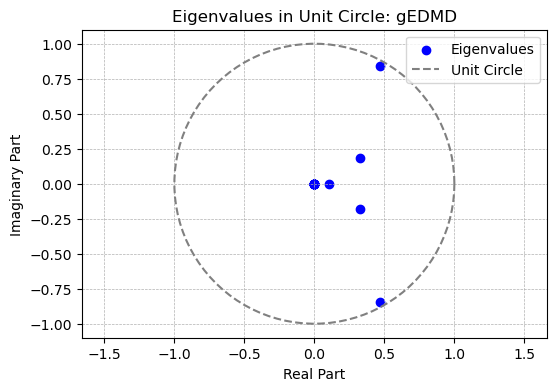

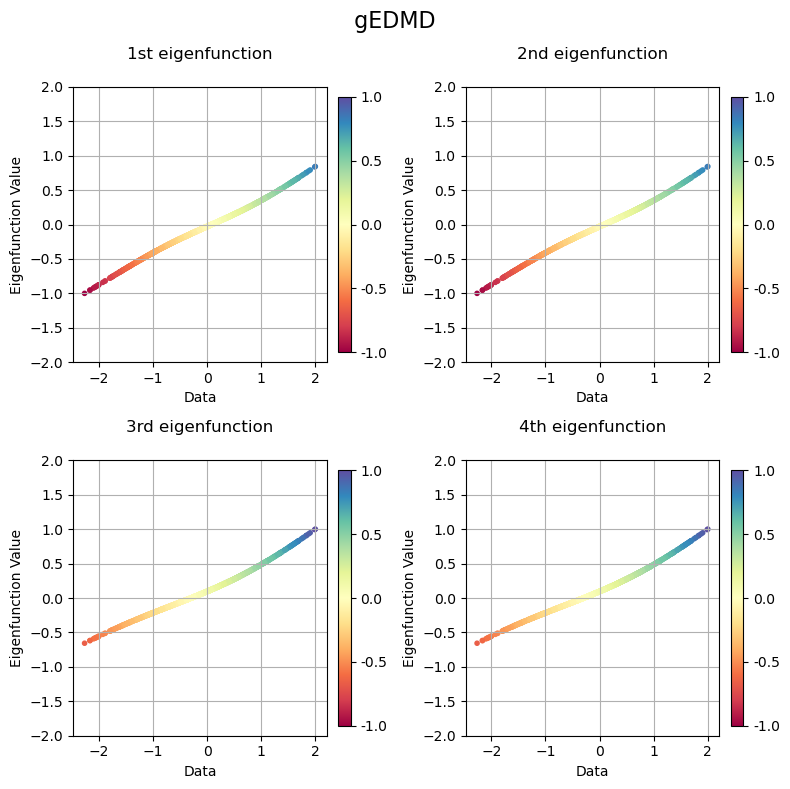

In [12]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()